<a href="https://colab.research.google.com/github/aradhanacha/NLP/blob/Classification_model/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [63]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import time
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter

In [47]:
#Define model paramater
TRAIN_SIZE=0.8
SEQUENCE_LENGTH=300
W2V_SIZE=300

In [5]:
data=pd.read_csv("mental_condition.csv")
data.head()

,Unnamed: 0,Text,Mental_condition
0,0,We understand that most people who reply immed...,1
1,1,Welcome to /r/depression's check-in post - a p...,1
2,2,Hey you. Yes you. You have done enough. You ar...,1
3,3,*Maybe a little bit of warmth? Maybe a hug peo...,1
4,4,After weeks of staring at my book shelf trying...,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13980 entries, 0 to 13979
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        13980 non-null  int64 
 1   Text              13851 non-null  object
 2   Mental_condition  13980 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 327.8+ KB


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Preprocess dataset


In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
%%time
data.Text = data.Text.apply(lambda x: preprocess(x))

CPU times: user 1.7 s, sys: 584 µs, total: 1.7 s
Wall time: 1.71 s


In [19]:
TRAIN_SIZE=0.8

#split Our dataset


In [27]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[=================================================-] 99.8% 1660.1/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [20]:
df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 11184
TEST size: 2796


In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 22567


In [33]:
SEQUENCE_LENGTH=300

In [34]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Text), maxlen=SEQUENCE_LENGTH)

In [36]:
x_train

array([[   0,    0,    0, ...,  106,  649,  119],
       [   0,    0,    0, ...,   30, 1187,   32],
       [   0,    0,    0, ...,   68,   99, 2243],
       ...,
       [   0,    0,    0, ...,  185,  216,  182],
       [   0,    0,    0, ...,    0,    0,  498],
       [   0,    0,    0, ..., 1884, 3103,  947]], dtype=int32)

In [37]:
labels = df_train.Mental_condition.unique().tolist()
labels

[0, 2, 1]

In [43]:


y_train = pd.get_dummies(df_train['Mental_condition']).values
y_test = pd.get_dummies(df_test['Mental_condition']).values
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (2796, 3)


In [44]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [45]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (11184, 300)
y_train (11184, 3)

x_test (2796, 300)
y_test (2796, 3)


#Train our model

In [51]:
model = Sequential()
model.add(Embedding(vocab_size, W2V_SIZE, input_length=SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          6770100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 6,930,803
Trainable params: 6,930,803
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
epochs = 8
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10065 samples, validate on 1119 samples
Epoch 1/8
10065/10065 [==============================] - 155s 15ms/step - loss: 0.5089 - accuracy: 0.7972 - val_loss: 0.2377 - val_accuracy: 0.9178
Epoch 2/8
10065/10065 [==============================] - 152s 15ms/step - loss: 0.1862 - accuracy: 0.9331 - val_loss: 0.2472 - val_accuracy: 0.9071
Epoch 3/8
10065/10065 [==============================] - 152s 15ms/step - loss: 0.1174 - accuracy: 0.9588 - val_loss: 0.2843 - val_accuracy: 0.9106
Epoch 4/8
10065/10065 [==============================] - 152s 15ms/step - loss: 0.0815 - accuracy: 0.9727 - val_loss: 0.3213 - val_accuracy: 0.9017


In [54]:
%%time
score = model.evaluate(x_test, y_test, batch_size=64)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2796/2796 [==============================] - 9s 3ms/step

ACCURACY: 0.8944921493530273
LOSS: 0.3466299689336226
CPU times: user 14.9 s, sys: 882 ms, total: 15.8 s
Wall time: 9.05 s


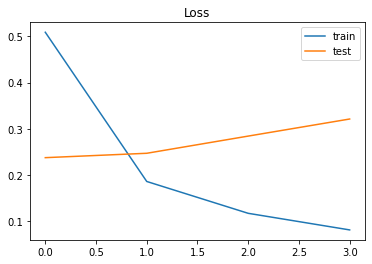

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
 

In [59]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

KeyError: ignored

In [98]:
%time
y_pred_1d = []
y_test_1d = list(df_test.Mental_condition)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [np.argmax(score) for score in scores]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
2796/2796 [==============================] - 8s 3ms/step


In [83]:
#confusion matrix

In [102]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1569
           1       0.83      0.82      0.83       629
           2       0.84      0.84      0.84       598

    accuracy                           0.89      2796
   macro avg       0.87      0.87      0.87      2796
weighted avg       0.89      0.89      0.89      2796



In [135]:
print(confusion_matrix(y_test_1d, y_pred_1d))

[[1481   56   32]
 [  49  517   63]
 [  48   47  503]]


#Inference

In [71]:
THRESHOLDS = (0.4, 0.8)

In [140]:
def decode_risk(stage,score):  
  if stage==0:
    label = 'NOT_SUICIDAL'
  elif stage==1:
    if score >= THRESHOLDS[1]:
      label='MID_RISK'
    else:
      label='EARLY_SIGN'
  else:
    label='HIGH RISK'

  return label 

In [141]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_risk(np.argmax(score),np.max(score))

    return {"label": label, "score": max(score),
       "elapsed_time": time.time()-start_at}  

In [143]:
predict("I want to die")

{'elapsed_time': 0.02681708335876465, 'label': 'HIGH RISK', 'score': 0.628511}

In [86]:
# EXPORT
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"
import pickle

In [88]:
model.save(KERAS_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)


#Predict few tweets

In [151]:
tweets=["I want to die","My life sucks","A am very angry","I am happy"," gave depression mad"]
for text in tweets:
  print(predict(text))

{'label': 'HIGH RISK', 'score': 0.628511, 'elapsed_time': 0.030074596405029297}
{'label': 'NOT_SUICIDAL', 'score': 0.46676832, 'elapsed_time': 0.021384716033935547}
{'label': 'NOT_SUICIDAL', 'score': 0.9550187, 'elapsed_time': 0.02448415756225586}
{'label': 'NOT_SUICIDAL', 'score': 0.9798881, 'elapsed_time': 0.021221399307250977}
{'label': 'MID_RISK', 'score': 0.99622214, 'elapsed_time': 0.01996302604675293}


In [150]:
df_train[df_train['Mental_condition']==1]

,Unnamed: 0,Text,Mental_condition
9792,45,wait longer depression talk past tense rather ...,1
11119,1372,gave depression mad,1
10452,705,craving unknown meal unknown streets unknown f...,1
10633,886,depression time high past weeks tired,1
493,493,aw man never gonna get outta rate,1
...,...,...,...
11636,1889,paths depression lead long white house congres...,1
466,466,forced take long time literally everyone even ...,1
11284,1537,complimenting weight loss weird bc going bad b...,1
11964,2217,saw typo spirit seasonal depression lazy distr...,1


#Lets see if we can load our model

In [152]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
new_m = load_model('model.h5')
# summarize model.
new_m.summary()


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          6770100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 6,930,803
Trainable params: 6,930,803
Non-trainable params: 0
_________________________________________________________________
